In [5]:
# All imports required for analysis are below
from __future__ import print_function
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import ipywidgets
from ipywidgets import widgets as wd
import sklearn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics as mt
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
import glob
import os
# Functions for ROC Graphs
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#probs is the result of a model.predict_proba(x_test) call

#This function plots an ROC curve
def rocCurvePlot(probs, y_test1):
    # calculate the fpr and tpr for all thresholds of the classification
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test1, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
# A function to find the optimal cutoff point from ROC curve

#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """Parameters:
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    ----------
    Return: list type, with optimal cutoff value
    """
    predicted = predicted[:,1]
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [31]:
# Loading in HTML/CSS packages for use within the notebook
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")

# Lab Two: Classification
### Group A: Mai Loan Tran, Lei Jiang, Zachary Gill, & Samantha Sprague

## Table of Contents for Lab 2
* <a href="#Introduction">Introduction</a>
* <a href="#CreateModels">Data Preparation</a>
* <a href="#ModelAdvantages">Modeling and Evaluation</a>
* <a href="#InterpretFeatureImportance">Deployment</a>
* <a href="#Exceptional Work">Exceptional Work</a>
* <a href="#References">References</a>



<a id="Introduction"></a>
## Introduction

Diabetes is the leading cause of death in the world. Roughly 422 million people have diabetes. There are three major types of diabetes: type 1, type 2, and gestational diabetes. Type 2 is the most common type of diabetes, and is thought to be preventable! While the leading cause of death, with identification and proper management of diabetes most individuals can lead happy and healthy lives. The key to manageable diabetes is often early detection and proper treatment. 

The first task of this notebook will guide the reader through a comprehensive analysis that evaluates our ability to predict readmission to the hospital for diabetes using advanced classification techniques: KNN, Random Forest, SVM, and XG Boost. The second task in this notebook will provide deep analysis to predict the amount of time a patient spent in the hospital for their condition using effective regression techniques: KNN, Random Forest, and Linear Regression.  

<a id="Data Preparation"></a>
## Data Preparation

## **DP Requirement 1**:

• Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

**DP Answer 1**: The types of data manipulation varied heavily by task and technique. This makes logical sense as certain techniques have sensitivity to outliers and skew while other models are non-parameteric and can perform without much feature engineering. The pre-processing techniques are described below by technique and task. It should be noted this is the same dataset our team used for the MiniLab and extensive work was done to clean the data set prior to loading in the data. The techniques listed below are only representative of the tasks specifically asked for in this notebook, and do not delve into the EDA done prior to this lab. We will use insights gleaned from prior labs in order to make decisions and assumptions in this lab (think: input variable distributions, etc). 

The data preparation of the KNN modeling technique consisted of categorizing and converting the data elements into its differing types, i.e. making age ordinal, medications binary, and leveraged several data pre-processing methods including PCA analysis, correlation evaluation, and t-statistic evaluation for feature selection. 

The data preparation for Random Forest and SVM modeling technique also used binary encoding for gender, ordinal encoding for age groups, one hot encoding for categorical variables, and normalization with StandardScaler. Based on the feature importance plot from the previous Lab 1 LR model, additional elements were combined with numerical features. 

The target response is readmitted_tf for Task 1 and time_in_hospital in Task 2.


#### KNN Pre-processing for Task One and Task Two

###### Pre-processing

In [32]:
# Importing Cleaned Data
directory = '/Users/samanthasprague/Downloads/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


In [33]:
# Making lists of different types
ordinal = ["age", "time_in_hospital"]
categorical = ["race", "gender", "admission_type_id", "discharge_disposition_id",
               "admission_source_id", "medical_specialty", "max_glu_serum",
               "A1Cresult", "change", "diabetesMed", "diag_1_val", "diag_2_val",
               "diag_3_val", "meds_increased"]
continuous = ["num_lab_procedures", "num_procedures", "num_medications",
              "number_outpatient", "number_emergency", "number_inpatient",
              "number_diagnoses", "medication_count"]
lcontinuous = ["lnum_lab_procedures", "lnum_procedures", "lnum_medications",
              "lnumber_outpatient", "lnumber_emergency", "lnumber_inpatient",
              "lnumber_diagnoses", "lmedication_count"]
medicines = ["metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
response = ["readmitted_tf"]

In [34]:
# Dataframes of each type of data
df_zg_ordinal = df_zg[ordinal]
df_zg_categorical = df_zg[categorical]
df_zg_continuous = df_zg[continuous]
df_zg_lcontinuous = np.log(df_zg_continuous)
df_zg_lcontinuous.columns = lcontinuous
df_zg_medicines = df_zg[medicines]
df_zg_response = df_zg[response]

In [35]:
# Making age ordinal
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ordinal.loc[df_zg_ordinal['age'] == val, 'age'] = i

In [36]:
# Making all necessary columns categorical
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['discharge_disposition_id'] = df_zg_categorical['discharge_disposition_id'].astype(object)
df_zg_categorical['admission_source_id'] = df_zg_categorical['admission_source_id'].astype(object)
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['meds_increased'] = df_zg_categorical['meds_increased'].astype(object)
#df_zg_response['readmitted_tf'] = df_zg_response['readmitted_tf'].astype(object)
print("Done")

Done


In [45]:
# Making DiabetesMed Binary
df_zg.diabetesMed[df_zg.diabetesMed == 'No'] = 0
df_zg.diabetesMed[df_zg.diabetesMed == 'Yes'] = 1

df_zg["diabetesMed"] = df_zg["diabetesMed"].astype(int)

In [37]:
# Creating different data sets 

# Original Data (no medication)
df_zg_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous], axis = 1)
# Just numerical values (with medications)
df_zg_num_x = pd.concat([df_zg_ordinal, df_zg_continuous], axis = 1)
# Original data (with medications) 
df_zg_med_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous, df_zg_medicines], axis = 1)
# One hot encoded dataset (no medications)
df_zg_hot_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous], axis = 1)
# One hot encoded (with medications)
df_zg_hot_med_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, pd.get_dummies(df_zg_medicines)], axis = 1)
# Response variable
df_zg_y = df_zg_response
print("Done")

Done


In [38]:
# Function for setting up training, validation, and test sets
def tvt_split(df_x, df_y, valid_size, t_size, seed):
    #doing the math because we have to split 2 separate times
    valid_size = 100*valid_size/(100*(1-t_size))
    #First splitting out the test set
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = t_size, random_state=seed)
    #Splitting the training set into train/validate
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = valid_size, random_state=seed)

    #Reseting all of the indices
    x_train.reset_index()
    y_train.reset_index()
    x_test.reset_index()
    y_test.reset_index()
    x_valid.reset_index()
    y_valid.reset_index()

    return x_train, x_valid, x_test, y_train, y_valid, y_test

###### T-statistic for Feature Evaluation

In [46]:
df = pd.concat([df_zg_hot_x, df_zg_response], axis = 1)
df0 = df.loc[df['readmitted_tf'] == 0]
df1 = df.loc[df['readmitted_tf'] == 1]
df0 = df0.drop(['readmitted_tf'], axis=1)
df1 = df1.drop(['readmitted_tf'], axis=1)

df0_s = df0.std(axis = 0).to_frame().T
df0_m = df0.mean(axis = 0).to_frame().T

df1_s = df1.std(axis = 0).to_frame().T
df1_m = df1.mean(axis = 0).to_frame().T

df0_c = pd.concat([df0_m, df0_s])
df1_c = pd.concat([df1_m, df1_s])

df0_c = df0_c.reset_index()
df1_c = df1_c.reset_index()

In [47]:
stuffs = []
for i in range(1,(len(df0_c.columns))):
    t = abs(df0_c.iloc[0,i] - df1_c.iloc[0,i])/(df0_c.iloc[1,i] + df1_c.iloc[0,i])
    stuffs.append(t)
nm = df0_c.columns.drop(['index']).values
df_c = pd.DataFrame(columns = nm)
df_c.loc[0] = stuffs
df_c.T.sort_values(by = 0, ascending = False)

,0
admission_source_id_22,1.000000
medical_specialty_Surgery-PlasticwithinHeadandNeck,1.000000
admission_source_id_25,1.000000
medical_specialty_Pediatrics-InfectiousDiseases,1.000000
medical_specialty_Resident,1.000000
medical_specialty_SportsMedicine,1.000000
medical_specialty_Pediatrics-AllergyandImmunology,1.000000
medical_specialty_Dermatology,1.000000
admission_source_id_10,1.000000
admission_type_id_7,0.775611


In [48]:
# Creating dataframe of top 10 values for t-statistic 
nm = ["admission_source_id", "medical_specialty", "admission_type_id",
      "discharge_disposition_id", "number_inpatient", "number_emergency",
      "meds_increased", "number_outpatient", "num_lab_procedures", "time_in_hospital"]
df_zg_minPCA = df_zg[nm]
df_zg_minPCA = pd.get_dummies(df_zg_minPCA)

scl = StandardScaler()
df_zg_PCA_scl = scl.fit_transform(df_zg_minPCA)

###### Correlation Evaluation for Feature Evaluation

In [49]:
# Printing the correlation of all values to the response
df_zg_corr = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, df_zg_response], axis = 1)
cors = df_zg_corr.corr()
cors = cors.sort_values(by=['readmitted_tf'])
cors.readmitted_tf

discharge_disposition_id_11                         -0.118405
discharge_disposition_id_1                          -0.116581
meds_increased_0                                    -0.099734
admission_type_id_3                                 -0.091221
diabetesMed_No                                      -0.083035
admission_source_id_1                               -0.077781
admission_source_id_2                               -0.076590
admission_type_id_4                                 -0.056889
discharge_disposition_id_14                         -0.049028
change_No                                           -0.046008
discharge_disposition_id_13                         -0.044504
race_Unspecified                                    -0.042900
medical_specialty_ObstetricsandGynecology           -0.040739
diag_3_val_None                                     -0.038082
medical_specialty_Orthopedics-Reconstructive        -0.033022
medical_specialty_Surgery-Cardiovascular/Thoracic   -0.031501
medical_

In [58]:
# Creating dataframe of all correlations >= |0.1|
nm = ["num_medications", "number_diagnoses", "admission_source_id", "time_in_hospital",
      "meds_increased", "number_emergency", "num_lab_procedures", "admission_type_id",
      "number_inpatient", "discharge_disposition_id"]
df_zg_minPCA = df_zg[nm]
df_zg_minPCA = pd.get_dummies(df_zg_minPCA)

scl = StandardScaler()
df_zg_PCA_scl = scl.fit_transform(df_zg_minPCA)

#### Random Forest and SVM Data Preparation

In [ ]:
# Import the data
directory = '/Users/samanthasprague/Downloads/'
df = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
df_clean = df

In [ ]:
df_clean.info()

In [ ]:
# Can also use binary encoder to achieve this
df_clean.gender[df_clean.gender == 'Male'] = 0
df_clean.gender[df_clean.gender == 'Female'] = 1

df_clean["gender"] = df_clean["gender"].astype(int)

In [ ]:
# 10 age groups; Ordinal encoding
# Feature density plot of age can help with answering the question like: does people older age tend to be readmitted?
# Can use map/apply function to achieve this

df_clean.age[df_clean.age== '[0-10)'] = 1
df_clean.age[df_clean.age== '[10-20)'] = 2
df_clean.age[df_clean.age== '[20-30)'] = 3
df_clean.age[df_clean.age== '[30-40)'] = 4
df_clean.age[df_clean.age== '[40-50)'] = 5
df_clean.age[df_clean.age== '[50-60)'] = 6
df_clean.age[df_clean.age== '[60-70)'] = 7
df_clean.age[df_clean.age== '[70-80)'] = 8
df_clean.age[df_clean.age== '[80-90)'] = 9
df_clean.age[df_clean.age== '[90-100)'] = 10

df_clean["age"] = df_clean["age"].astype(int)

In [ ]:
# One hot encoding categorical variables

# FE based on Feature Importance plot from LR model

# Add more important features: discharge_disposition_id, admission_source_id
# We think they should be categorical, so we put them in dummy list
# Also included all medications

dummiesList=["diag_1_val","diag_2_val","diag_3_val","race","A1Cresult","admission_type","admission_source","discharge_disposition",
             "diabetesMed","medical_specialty", "max_glu_serum", "meds_increased", "insulin",
            "metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
df_clean_wDummies = pd.get_dummies(df_clean[dummiesList])

In [ ]:
# Combine with numerical features we decided to use and target readmitted_tf
NumFeatures=["num_lab_procedures","num_procedures","number_outpatient","number_emergency", "number_inpatient","num_medications",
             "medication_count","number_diagnoses", "gender","age","readmitted_tf"]
df_clean_wDummies= pd.concat((df_clean_wDummies, df_clean[NumFeatures]), axis=1)

In [ ]:
df_clean_wDummies.info()

In [ ]:
df_imputed=df_clean_wDummies

from sklearn.model_selection import ShuffleSplit

# We want to predict the X and y data as follows:
if 'readmitted_tf' in df_imputed:
    y = df_imputed['readmitted_tf'].values # get the labels we want
    del df_imputed['readmitted_tf'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# To use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

## **DP Requirement 2**:

• Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

**DP Answer 2**: The final datasets with input variables and targets for this assignment depended not only on the task, but also the technique leveraged. Below you will find robust documentation on the features and target of each final model selected for that technique. 

During the data cleaning stage, we also added two new features. The first was 'medication_count', which is the number of prescriptions the patient was prescribed. This differs from the 'num_medications', which is the number of medications administered during the encounter. The second new feature was 'meds_increased', a binary feature that identifies whether there was change in the patient's diabetes medication.


#### Task One Dataset Description: Binary Classification on Readmittance

##### KNN

!! ZACK!!
Based on the data preparation above, 2 different KNN models were built: 1. KNN with full dataset, 2. KNN with top 10 variables from T-statistic, and lastly a KNN with top 10 input variables from coorelation to the repsonse. We found that by using the top 10 variables from the correlation to the response, we were able to achieve the best model in accuracy and AUC on the test set. This is discussed more below. The features for the final KNN reported here are: 

| Variable Name | Type |Definition |
|---------------|------|-----------|
| num_medications | Continous | New feature created, sum of count of medications per patient, per encounter|
| number_diagnoses | Continous | Number of diagnoses entered in the system |
| admission_source_id | Categorical | Source of admission |
| time_in_hospital | Contious | Number of days between admission and discharge |
| meds_increased | Flag | New feature created, identifies if there was change in the patient's diabetes medication |
| number_emergency | Continous | Number of emergency visits in the year preceding the encouunter |
| num_lab_procedures | Continous | Number of lab tested performed during encounter |
| admission_type_id | Categorical | Type of admission in the hospital
| number_inpatient | Continous | Number of inpatient visits in the year preceding the encounter
| discharge_disposition_id | Categorical | Reason for discharge
| readmitted | Flag | Target variable: either "NO", "<30" or ">30"

##### Random Forest and SVM

In [ ]:
!! SAM !!
The final RF and SVM variables actual used for Task 1 are below based on MiniLab LR.

dummiesList=["diag_1_val","diag_2_val","diag_3_val","race","A1Cresult","admission_type","admission_source","discharge_disposition",
             "diabetesMed","medical_specialty", "max_glu_serum", "meds_increased", "insulin",
            "metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]

NumFeatures=["num_lab_procedures","num_procedures","number_outpatient","number_emergency", "number_inpatient","num_medications",
             "medication_count","number_diagnoses", "gender","age",
             
Target "readmitted_tf"]

Tried full dataset, full dataset parameter tuning, feature important 13 variables (data frame minial) 

#### Task Two Dataset Description: Regression on Time in Hospital 

######  KNN

In [ ]:
!! Zack !!

###### Random Forest

In [ ]:
!! Sam !!
dummiesList=["diag_1_val","diag_2_val","diag_3_val","race","A1Cresult","admission_type","admission_source","discharge_disposition",
             "diabetesMed","medical_specialty", "max_glu_serum", "meds_increased", "insulin",
            "metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]

NumFeatures=["num_lab_procedures","num_procedures","number_outpatient","number_emergency", "number_inpatient","num_medications",
             "medication_count","number_diagnoses", "gender","age"]

Target "time_in_hospital"

######  Linear Regression

!! SAM !!

For linear regression, the final data set consisted of 11 variables: 'discharge_disposition','admission_source', 'admission_type','age', 'num_medications', 'number_diagnoses', 'number_emergency', 'num_lab_procedures', 'number_inpatient', 'medication_count', 'readmitted_tf'. 


<a id="Modeling and Evaluation"></a>
## Modeling and Evaluation

## **ME Requirement 1**:

• Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation
backing up any assertions.

**ME Answer 1**: The best data scientists and engineers will use a combination of accuracy, precision, recall, F-measure, and AUC model evaluation metrics on the test and/or validation sets to determine the best model for the task. Depending on the problem the model is trying to solve (or the purpose for prediction) and the technique being used to solve the problem, a data scientist might lean on one metric over another.

The University of San Fransico Data Institute put together a useful diagram that provides a useful summary of when data scientists and engineers may want to lean on one metric over another. (Figure 1) [6]

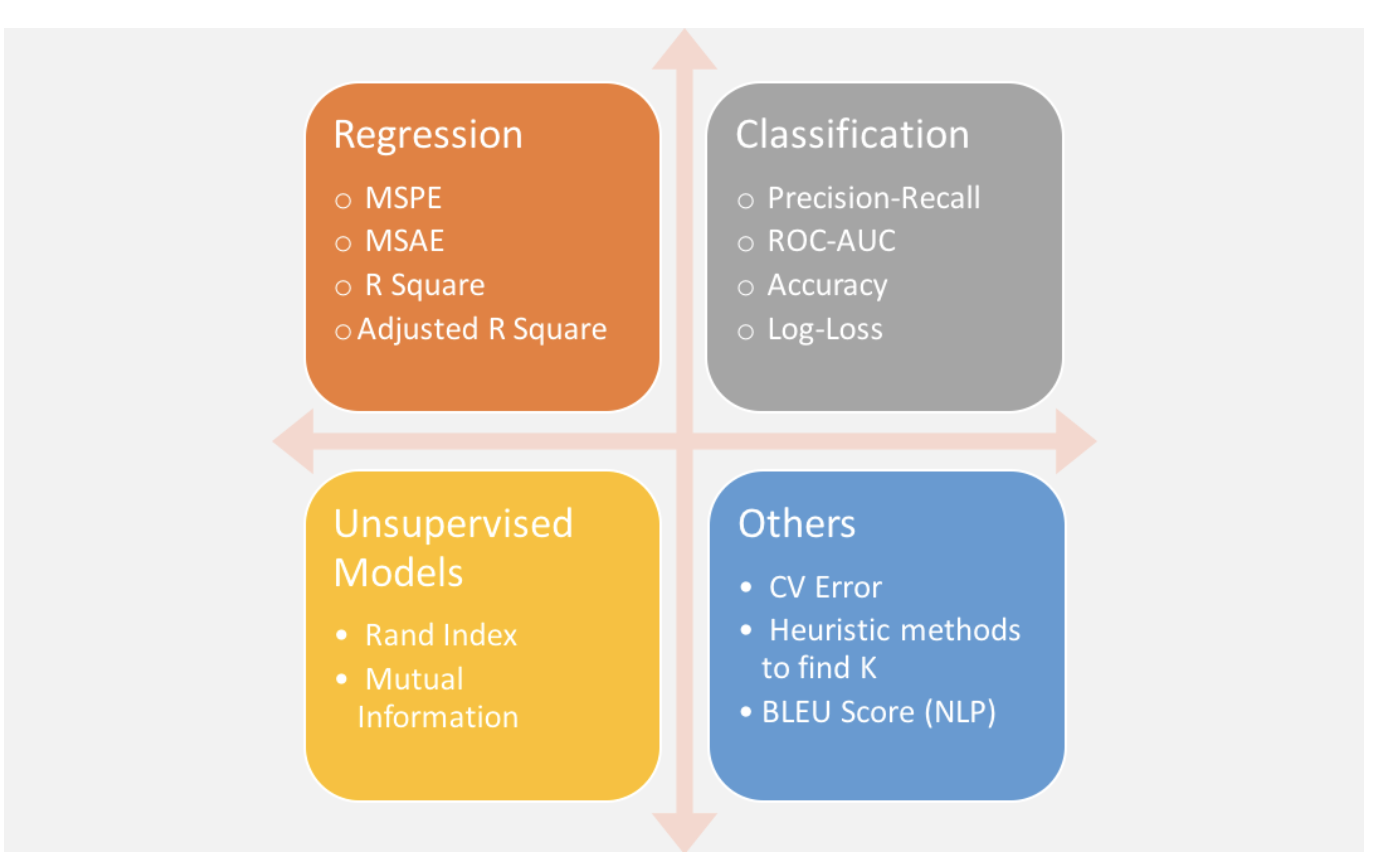

In [10]:
from IPython.display import Image
Image(filename='/Users/samanthasprague/Desktop/1.png')

One generic example for classification models is the case of medical diagnosis. When building machine learning models for medical purposes, the precision of those models needs to be very high. Inappropriately diagnosing people that are healthy has a very dangerous outcome: inappropriate treatment, etc. And missing the diagnosis on unhealthy people, can also have a dangerous outcome: increase in pain/symptoms and potentially, death. By focusing on precision, the number of positive cases that are correctly identified, we minimize the false positives and can ensure we are focused on only diagnosising individuals we are confident are sick. 

On the contrary, when using machine learning models for prediction in the marketing space, the outcome of incorrectly classifing a potential customer does not particularly have a dangeorus outcome. At most, a company could spend more money and not see as much financial gain. Thus, precision is not a metric heavily used in marketing machine learning models, instead, these data scientists will focus on optimizing for the most insights, regardless of how high the false positive rate is. In this case, leveraging the F1-score which take into account both precision and recall. Maximizing this number will allow for the best model. [3]


Both of these examples have been classification problems. The tables turn when we are looking to evaluate models for regression. Regression evaluation methods truly depend specifically on the task at hand. There is value to evaluating model performance with all the metrics above listed, but will be determined on a case by case basis. As always, a train and test split is your best way to validate or prevent a model from overfitting. Thus, it is important to test these metrics against your test set when evaluating a model. 

Based on our experience in the field and research, **task one will rely on AUC most heavily to determine best fit.** The reason for this is because we are trying to predict whether a patient will be readmitted to the hospital for diabetes. While this model does allow benefit for the medical field, the purpose is not to diagnose, but rather provide insight into future treatment or needs. There are multiple benefits to a model like this, from staffing and readmittance estimates, to proper diagnosis and follow up. By leveraging AUC, we provide an analysis that leverages the ROC curve as a visual representation of all classification thresholds. These metrics are insensitive to whether your predicted probablities are properly calibrated. [4] In other words, the ROC curve "shows you how many correct positive classifications can be gained as you allow for more and more false positives. The perfect classifier that makes no mistakes would hit a true positive rate of 100% immediately, without incurring any false positives---this almost never happens in practice." [2] In addition, this is a useful metric for datasets with unbalanced classes. It is for these reasons, we will lean heavily on the AUC to compare models. The highter the AUC, the greater area under the (ROC) curve, and thus, the better at prediction the model will be.  

**For task two, because our task is regression, MSE will be the metric we rely on most heavily to determine best fit.** MSE or mean squared error is the average of the squared errors, or in plain english, the average squared difference between the predictions and actual outcomes. The reason we chose this is because it is much simplier to interpret. RSME was another potential option but is more complex and is biased toward higher deviations, in addition to not being robust to outliers. [6] We will also lean on adjusted $R^{2}$ to provide some insight while selecting the best regression models internal to the technique.  

## **ME Requirement 2**:
• Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.

**ME Answer 2**: The method used for dividing our data in training and testing splits was dependent on the task and techique leveraged. Below is the analysis done for each task and technique. 

#### Task One Training and Test Split: Binary Classification on Readmittance

###### KNN

Our complete dataset contained over 100k points. Thus, due to the amount of data points, the length of time it took to complete just one training cycle of a model took over 15+ minutes. Due to the processing limitations, we decided against leveraging cross validation within our KNN training as it took over 1 hr to run when attempted. However, we did leverage a train, test, and validation split. The KNN model training was done on the train set. All parameter tuning done on the validation set. All formal model evaluation metrics were done on the test set.

In [ ]:
%%time
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_minPCA, df_zg_y, 0.2, 0.2, 7)

# Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

# Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid
y_tst = y_test

# We will fill this with predictions
yhat = np.zeros(y_v.shape)

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.transform(x_valid)
x_tst = scl.transform(x_test)

###### Random Forest

The random forest model leveraged a train and test split. We created the model on train set with 3-fold cross valudation. Then, we performed parameter tuning on the train set and all model evaluation on the test set. 

In [ ]:
## Training and Testing Split
# Run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

In [ ]:
# We want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the test data to find out the mean and std (this would be snooping)
# To make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

###### SVM

The SVM model also leveraged train and test split. The model was trained on the train set with parameter tunning performed on the train set, and model evaluation done on the test set. 

In [ ]:
!! Sam !!
#help, @ Lei did you use the same training and testing sets 
#for SVM and RF??????

#### Task Two Training and Test Split: Regression on Time in Hospital

###### KNN

In [ ]:
!! SAM !!
#need
#@ zach did we use same training and testing sets?? 
#i assumed they changed because the target changed? i couldn't find it
#in your notebook

###### Random Forest

In [ ]:
!! SAM !!

###### Linear Regression

In [ ]:
!! SAM !!

## **ME Requirement 3**:
• Create three different classification/regression models (e.g., random forest, KNN, and SVM) for each task. Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.

**ME Answer 3**: We created 3 different models per technique. The tasks are described below, and the models are separated by task. Each model included a base line, hyper-parameter tuning, and the final model with the tuned parameters.  

* Task One: Binary Classification of Readmittance (0 or 1)
* Task Two: Regression on Time in Hospital 

#### Task One Model Creation: Binary Classification of Readmittance

###### KNN

In [ ]:
%%time
# Get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors = 27)
clf.fit(x_t, y_t)

In [ ]:
%%time
# Find the optimal cutoff point
y_pred_cut = clf.predict_proba(x_t)
cutoff = Find_Optimal_Cutoff(y_t, y_pred_cut)

# Prediction
# y_pred = model.predict(x_test_scaled)
y_pred_probs = clf.predict_proba(x_v)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs, y_v)


# Accuracy metrics
f1 = f1_score(y_v, y_pred, average = 'weighted')
acc = accuracy_score(y_v, y_pred)
roc = roc_auc_score(y_v, y_pred_probs[:,1])
#roc = roc_auc_score(y_v, clf.predict_proba(x_v)[:,1])
conf = mt.confusion_matrix(y_v, y_pred)
print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)

##### KNN Tuning on reduced set
###### Testing 1-50 (odd values)
Creates the model for each of the K's in that range and then saves the AUC for the train and validation sets.

In [ ]:
%%time
# creating odd list of K for KNN
myList = list(range(1,50))
# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
scores = pd.DataFrame(columns = ["K", "AUC_Train", "AUC_Valid"])

i = 0
for k in neighbors:
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(x_t, y_t)

    #AUC
    auc_t = roc_auc_score(y_t, clf.predict_proba(x_t)[:,1])
    auc_v = roc_auc_score(y_v, clf.predict_proba(x_v)[:,1])
    scores.loc[i] = [k, auc_t, auc_v]
    i = i+1

###### Testing 50-70 (odd values)
Creates the model for each of the K's in that range and then saves the AUC for the train and validation set.

In [ ]:
%%time
# creating odd list of K for KNN
myList = list(range(50,70))
# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
scores1 = pd.DataFrame(columns = ["K", "AUC_Train", "AUC_Valid"])

i = 0
for k in neighbors:
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(x_t, y_t)

    #AUC
    auc_t = roc_auc_score(y_t, clf.predict_proba(x_t)[:,1])
    auc_v = roc_auc_score(y_v, clf.predict_proba(x_v)[:,1])
    scores1.loc[i] = [k, auc_t, auc_v]
    i = i+1

###### Plotting K's 1 - 70 (odd values)
Using the validation set in order to see how large of a k to use. From the plot below we can see the they are asymptotically approaching 0.73. Because this is a large dataset (100k+ rows) we can use a little larger k and we will not run a big risk of overfitting. Based on the data below a K of 15 would be a good choice.

In [ ]:
df_scores_0_70 = pd.concat([scores, scores1])
df_scores_0_70.columns = ["K", "AUC_Train", "AUC_Valid"]

plt.plot(df_scores_0_70.K, df_scores_0_70.AUC_Valid)
plt.plot(df_scores_0_70.K, df_scores_0_70.AUC_Train)

plt.xlabel('K') 
plt.ylabel('AUC') 
plt.legend()
plt.title('Training vs Validation AUC') 

plt.show()

###### KNN with the above parameters
Now that we have tuned the values for K, we do the prediction on the test set. Below shows the ROC curve with all of the accuracy metrics and confusion matrix.

In [ ]:
%%time
clf = KNeighborsClassifier(n_neighbors = 15)
clf.fit(x_t, y_t)

In [ ]:
%%time
#Find the optimal cutoff point
y_pred_cut = clf.predict_proba(x_t)
cutoff = Find_Optimal_Cutoff(y_t, y_pred_cut)

#Prediction
y_pred_probs = clf.predict_proba(x_tst)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs, y_tst)

#Accuracy metrics
f1 = f1_score(y_tst, y_pred, average = 'weighted')
acc = accuracy_score(y_tst, y_pred)
auc = roc_auc_score(y_tst, y_pred_probs[:,1])
conf = mt.confusion_matrix(y_tst, y_pred)
sens = conf[0,0]/(conf[0,0] + conf[0,1])
spec = conf[1,1]/(conf[1,0] + conf[1,1])
print("F1:", round(f1,4), "ACC:", round(acc,4), "AUC:", round(auc,4))
print("Specificity:", round(spec, 4), "Sensitivity:", round(sens, 4))
print("\nConfusion Matrix\n", conf)

###### Random Forest

In [ ]:
#RF baseline model
%%time
#run for 1-2 mins
NUM_ESTIMATORS = 100
NO_JOBS = 4
RANDOM_STATE = 2000        
        
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(  random_state = RANDOM_STATE, criterion = 'gini', 
                                n_estimators = NUM_ESTIMATORS, verbose = False, n_jobs = NO_JOBS)
rf_clf.fit(X_train_scaled,y_train)

preds = rf_clf.predict(X_test_scaled)
print('Random Forest - roc_auc_score: ', roc_auc_score(y_test, preds)) 

#before Hyperparameter Tuning  
#run 1 Random Forest - roc_auc_score:  0.6691330626808287
#run 2 Random Forest - roc_auc_score:  0.6746304273089445

# The reason I want to keep both baseline model and refined model is to show the effect of Hyperparameter Tuning,
#increase the AUC by what percentage

In [ ]:
#Confusion Matrix
cm = pd.crosstab(y_test, preds, rownames = ['Actual'], colnames = ['Predicted'])
fig, (ax1) = plt.subplots(ncols = 1, figsize = (5, 5))
sns.heatmap(cm, xticklabels = ['readmitted_0', 'readmitted_1'], yticklabels = ['readmitted_0', 'readmitted_1'], 
            annot = True, ax = ax1,
            linewidths = .2, linecolor = 'Darkblue', cmap ='Blues')
plt.title('confusion Matrix', fontsize = 14)
plt.show()

In [ ]:
rf_clf.feature_importances_

In [ ]:
from pprint import pprint

# Look at parameters used by our current base model forest
print('Parameters currently in use:\n')
pprint(rf_clf.get_params())




#Parameters currently in use:

#{'bootstrap': True,
# 'class_weight': None,
# 'criterion': 'gini',
# 'max_depth': None,
# 'max_features': 'auto',
# 'max_leaf_nodes': None,
# 'min_impurity_decrease': 0.0,
# 'min_impurity_split': None,
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'min_weight_fraction_leaf': 0.0,
# 'n_estimators': 100,
# 'n_jobs': 4,
# 'oob_score': False,
# 'random_state': 2000,
# 'verbose': False,
# 'warm_start': False}

Hyperparameter Tuning - Random Forest
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

https://github.com/WillKoehrsen/Machine-Learning-Projects/tree/master/random_forest_explained

We will try adjusting the following set of hyperparameters:

n_estimators = number of trees in the foreset (more trees make the model more stable)
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)
RandomizedSearchCV
Grid Search with Cross Validation
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV.

Comparing randomized search and grid search for hyperparameter estimation
The randomized search and the grid search explore exactly the same space of parameters. The result in parameter settings is quite similar, while the run time for randomized search is drastically lower.

The performance is slightly worse for the randomized search, though this is most likely a noise effect and would not carry over to a held-out test set.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html

In [ ]:
## Random Search Training

#from previous assignment MiniLab1, I figured subsampling with 20% of data and do GridSearch for SVM reduce the run time sigificantly.
#and yield the same tuning results.
#from 4 hrs to 20 mins, that is 8x of time
#so I decide to do this again to save some training time. Train for the entire dataset ues the same code,just takes much longer.


In [ ]:
#subsample 20% of our data 

subsam_df_imputed=df_imputed.sample(frac=0.2)

In [ ]:
subsam_df_imputed.info()

In [ ]:
df_imputed=subsam_df_imputed
df_imputed.info()

In [ ]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'readmitted_tf' in df_imputed:
    y = df_imputed['readmitted_tf'].values # get the labels we want
    del df_imputed['readmitted_tf'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

In [ ]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

    # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

## Random Hyperparameter Grid - RandomizedSearchCV

In [ ]:
#Random Hyperparameter Grid - RandomizedSearchCV

#To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [ ]:
#run for 1hr

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100? different combinations, and (use all available cores-n job =-1)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 3, verbose=False, random_state=2000, n_jobs = 4)

# Fit the random search model
rf_random.fit(X_train, y_train)

The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 5 and 3 respectively). (start n_iter with a small number to get estimation of runtime) (Fitting 3 folds for each of 5 candidates, totalling 15 fits-see if it is around 15 mins, since base model run for 1 min-for full dataset) (running for 15 mins now, still running) (running for half an hour and still runing.so stopped and change n iter to 1, just try to see how much time it will take)

More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [ ]:
#view the best parameters from fitting the random search:
rf_random.best_params_


#Out[19]:
#{'n_estimators': 1800,
# 'min_samples_split': 10,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': 50,
# 'bootstrap': False}

In [ ]:
#run for 5 mins  n_estimators = 1800  (base model n_estimators = 100)

#evaulate the performance of the model best parameters
#test the improvement of auc using rf_random.best_params_

#Out[19]:
#{'n_estimators': 1800,
# 'min_samples_split': 10,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': 50,
# 'bootstrap': False}

rf_clf = RandomForestClassifier(  random_state = RANDOM_STATE, criterion = 'gini', min_samples_split=10,min_samples_leaf=1,
                                max_features='sqrt', max_depth=50, bootstrap = False,
                                n_estimators = 1800, verbose = False, n_jobs = NO_JOBS)
rf_clf.fit(X_train_scaled,y_train)

preds = rf_clf.predict(X_test_scaled)
print('Random Forest - roc_auc_score: ', roc_auc_score(y_test, preds)) 
#Random Forest - roc_auc_score:  0.6797954420410847
#run2 Random Forest - roc_auc_score:  0.6776931710399214

In [ ]:
random_accuracy = 0.6776931710399214
base_accuracy =0.6682573532018597

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Type Markdown and LaTeX:  𝛼2

###### SVM

In [ ]:
#Lei to add the subsampling code and modify the dataframe

In [ ]:
# lets investigate SVMs on the data and play with the parameters and kernels
#%%time
#try run with all medications

from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

In [ ]:
#get SVM ACC

from sklearn import metrics as mt

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)

print('SVM accuracy:', acc )
print(conf)

# SVM accuracy: 0.6815859290557139
#acc is lower compare with svm model without med accuracy: 0.6822246241525007
#run longer than svm model without med
#but decide to keep these bc RF does not require the assumption of multicolinearity

In [ ]:
#get SVM AUC
roc = roc_auc_score(y_test,y_hat)
print('SVM AUC:', roc )

#SVM AUC: 0.6658213006434637

In [ ]:
#SVM_SGD

#SGD made SVM model train fast. this was done in seconds comparing with no SGD 14 mins run.
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn import metrics as mt
cv = StratifiedShuffleSplit( n_splits=1,test_size=0.5)
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM_SGD:', acc)
roc = roc_auc_score(y_test,y_hat)
print('SVM AUC:', roc )

# For Dummlist
#dummiesList=["diag_1_val","diag_2_val","diag_3_val","race","A1Cresult","admission_type","admission_source","discharge_disposition",
             #"metformin", "repaglinide", "nateglinide", "chlorpropamide",
             #"glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             # "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             #"tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             #"metformin-rosiglitazone", "metformin-pioglitazone"]
#SVM_SGD: 0.6552679676905843 comparing without medications(only insulin included model) which had SVM_SGD: 0.655405538195468
#only a slight increase so not worth including all medications for SVM




#### Task Two Model Creation: Regression on Time in Hospital

######  KNN

In [ ]:
!!!!!!ZACK MAKE THE DATA SET FOR BOTH FULL AND MOST HIGHLY CORRELATED MODELS!!!!!!!

In [ ]:
# Train and test validation split for KNN for full model with the Task 2 target time_in_hospital
%%time
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_hot_x, df_zg_y, 0.2, 0.2, 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

#Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid
y_tst = y_test

# We will fill this with predictions
yhat = np.zeros(y_v.shape)

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.transform(x_valid)
x_tst = scl.transform(x_test)

Testing 1-20 (odd values)
Creates the model for each of the K's in that range and then saves the AUC for the train and validation sets.

In [ ]:
%%time
#https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/
# creating odd list of K for KNN
myList = list(range(1,20))
# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
scores = pd.DataFrame(columns = ["K", "MSE_Train", "MSE_Valid"])

i = 0
for k in neighbors:
    clf = KNeighborsRegressor(n_neighbors = k)
    clf.fit(x_t, y_t)

    #AUC
    mse_t = mean_squared_error(y_t, clf.predict(x_t))
    mse_v = mean_squared_error(y_v, clf.predict(x_v))
    scores.loc[i] = [k, mse_t, mse_v]
    i = i+1
    print(k)

Plotting K's 1 - 20 (odd values)
Using the validation set in order to see how large of a k to use. From the plot below we can see the they are asymptotically approaching 6.8. Because this is a large dataset (100k+ rows) we can use a little larger k and will not run a large risk of overfitting. Based on the data below a K of 9 would be a good choice.

In [ ]:
df_scores_0_70 = scores
#df_scores_0_70 = pd.concat([scores, scores1])
df_scores_0_70.columns = ["K", "MSE_Train", "MSE_Valid"]

plt.plot(df_scores_0_70.K, df_scores_0_70.MSE_Valid)
plt.plot(df_scores_0_70.K, df_scores_0_70.MSE_Train)

plt.xlabel('K') 
plt.ylabel('MSE') 
plt.legend()
plt.title('Training vs Validation MSE') 

plt.show()

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Stick pic here !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
# Running the full model
%%time
model = KNeighborsRegressor(n_neighbors = 9)
model.fit(x_t, y_t)
%%time
#Find the optimal cutoff point
y_pred = model.predict(x_tst)

#Calculate the MSE
error = mean_squared_error(y_tst, y_pred)

#Printing the results
print("MSE:", error)

In [ ]:
# Correlation of the Task 2 target time_in_hospital
df_zg_corr = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, df_zg_response], axis = 1)
cors = df_zg_corr.corr()
cors = cors.sort_values(by=['time_in_hospital'])
cors.time_in_hospital

In [ ]:
nm = ["num_medications", "discharge_disposition_id", "num_procedures", "number_diagnoses",
     "num_lab_procedures", "meds_increased", "admission_source_id", "readmitted_tf",
     "change", "age"]
df_zg_minPCA = df_zg[nm]
df_zg_minPCA = pd.get_dummies(df_zg_minPCA)

In [ ]:
# Train and test validation split for KNN based upon most correlated with the Task 2 target
%%time
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_minPCA, df_zg_y, 0.2, 0.2, 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

#Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid
y_tst = y_test

# We will fill this with predictions
yhat = np.zeros(y_v.shape)

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.transform(x_valid)
x_tst = scl.transform(x_test)

In [ ]:
Testing 1-50 (odd values)
Creates the model for each of the K's in that range and then saves the AUC for the train and validation sets.

In [ ]:
%%time
#https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/
# creating odd list of K for KNN
myList = list(range(1,50))
# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
scores = pd.DataFrame(columns = ["K", "MSE_Train", "MSE_Valid"])

i = 0
for k in neighbors:
    clf = KNeighborsRegressor(n_neighbors = k)
    clf.fit(x_t, y_t)

    #AUC
    mse_t = mean_squared_error(y_t, clf.predict(x_t))
    mse_v = mean_squared_error(y_v, clf.predict(x_v))
    scores.loc[i] = [k, mse_t, mse_v]
    i = i+1
    print(k)

Plotting K's 1 - 50 (odd values)
Using the validation set in order to see how large of a k to use. From the plot below we can see the they are asymptotically approaching 6.8. Because this is a large dataset (100k+ rows) we can use a little larger k and will not run a large risk of overfitting. Based on the data below a K of 9 would be a good choice.

In [ ]:
df_scores_0_70 = scores
#df_scores_0_70 = pd.concat([scores, scores1])
df_scores_0_70.columns = ["K", "MSE_Train", "MSE_Valid"]

plt.plot(df_scores_0_70.K, df_scores_0_70.MSE_Valid)
plt.plot(df_scores_0_70.K, df_scores_0_70.MSE_Train)

plt.xlabel('K') 
plt.ylabel('MSE') 
plt.legend()
plt.title('Training vs Validation MSE') 

plt.show()

In [ ]:
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Stick pic here !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
# Running the model with most highly correlated elements
%%time
model = KNeighborsRegressor(n_neighbors = 5)
model.fit(x_t, y_t)
%%time

#Find the optimal cutoff point
y_pred = model.predict(x_tst)

#Calculate the MSE
error = mean_squared_error(y_tst, y_pred)

#Printing the results
print("MSE:", error)

######  Random Forest

In [ ]:
!!!LEI TO ADD DATASET CODE !!!!!

In [ ]:
## Code to train a model and calc the R-sq 
## This iece of code trains a RandomForest Regressor 
if "time_in_hospital" in df.columns:
    yData = df.time_in_hospital
    del df["time_in_hospital"]
xData = df
X_train, X_test, y_train, y_test = train_test_split(xData,yData)

In [ ]:
    # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [ ]:
#RF Regressor baseline model
rf=RandomForestRegressor()
rf.fit(X_train_scaled,y_train)

In [ ]:
predicted_time_in_hospital = rf.predict(X_test)

In [ ]:
predicted_time_in_hospital[:10]

In [ ]:
#metrics.mean_squared_error
mean_squared_error(y_test, predicted_time_in_hospital)

In [ ]:
print(rf.feature_importances_)

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=df.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
from pprint import pprint

# Look at parameters used by our current base model forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [ ]:
#Random Hyperparameter Grid - RandomizedSearchCV

#To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

In [ ]:
#guess run for 1hr; actual 40 min
# Use the random grid to search for best hyperparameters

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100? different combinations, and (use all available cores-n job =-1)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 3, verbose=False, random_state=2000, n_jobs = 4)

# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
#view the best parameters from fitting the random search:
rf_random.best_params_

#{'n_estimators': 1800,
# 'min_samples_split': 10,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': 50,
# 'bootstrap': False}

In [ ]:
#
rf_best = RandomForestRegressor(  random_state = 2000, min_samples_split=10,min_samples_leaf=1,
                                max_features='sqrt', max_depth=50, bootstrap = False,
                                n_estimators = 1800, verbose = False, n_jobs = 4)
rf_best.fit(X_train_scaled,y_train)

preds = rf_best.predict(X_test_scaled)

In [ ]:
#metrics.mean_squared_error
mean_squared_error(y_test, preds)

In [ ]:
# mse decrease after parameter tuning
random_mse = 5.835765214548177
base_mse = 38.996052590205174

print('Improvement of {:0.2f}%.'.format( 100 * (base_mse - random_mse) / base_mse))
#Improvement of 85.03%. afater parameters tuning

In [ ]:
feat_importances = pd.Series(rf_best.feature_importances_, index=df.columns)
feat_importances.nlargest(15).plot(kind='barh')

######  Linear Regression

In [ ]:
!!!!!!INSERT ZACK's CODE THE DATA SET FOR MOST HIGHLY CORRELATED MODELS!!!!!!!

In [ ]:
from sklearn.linear_model import LinearRegression
linearRegressor = LinearRegression()

linearRegressor.fit(X_train_scaled , y_train)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, yPrediction)

#MSE with draft features and no parameters tuning:
#7.175072072572132

In [ ]:
!!! ZACK TO ADD PLOTS FOR CATEGORICAL and NUMERICAL VARIABLES to check for linear corr, i.e. pairs plots

## **ME Requirement 4**:

• Analyze the results using your chosen method of evaluation. Use
visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

**ME Answer 4**:

#### Task One Evaluation: Binary Classification of Readmittance

| Model Type | AUC | TP | TN | Accuracy |
|------------|-----|----|----|----------|
|KNN: Task One| 0.6958 | 0.6389 | 0.6342 | 0.6367 |
|Random Forest: Task One| --| -- | -- | -- |
|SVM: Task One| -- | -- | -- | -- |


In [ ]:
# help need visuals
# ZACK to add KNN ROC curve
# LEI to add RF and SVM AUC, specificity, sensitivity, and Accuracy and corresponding ROC curves
# SAM to write

Out of all of the classifers KNN seems to provide the best AUC. 

#### Task Two Evaluation: Regression of Time in Hospital 

| Model Type | MSE |
|------------|-----|
|KNN: Task Two| 7.44 |
|Random Forest: Task Two| 5.84 |
|Linear Regression: Task Two| 7.18 |

In [ ]:
# ZACK to add visual for MSE, train vs validation
# SAM to write

## **ME Requirement 5**:

• Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.

**ME Answer 5:** Discussed below are the advantages and disadvantages for each classifcation and/or regression technique used to solve to the two tasks. 

Advantages of KNN Classifer: 

* Robust to noisy training data [13]
* Effective if the training data is large 

Some disadvantages is that it can be difficult to find the optimal value of K. The type of distance used in the KNN can be difficult to optimize. Lastly, computation costs of a KNN are high because each distanced needs to be calculated for all training samples. In our case, there were over 65k training samples. 

Advantages of Random Forest Classifer:

* Provides an ensemble method 
* Reduction in overfitting by subsampling your data
* Less variance, by creating multiple trees you reduce the variance of just one classifier. 

Some disadvantages are that random forrests are complex and therefore difficult to analyze. In addition, the computation time is expensive. 

Advantages of SVM Classifer: 

* SVMs can unlock complex relationships not always indentified with LRs 
* Has more parameters that allow for specific tuning 
* Has non-parametric option (RBF, aka the Kernel Trick) for increase in accuracy 
* See a large performance gain for training time when leveraging SGD 
* Can be used for many data types 
* Not as sensitive to outliers compared to LR
* SVM has less predicition time because only points near the boundary make a difference

Advantages of Linear Regression Regessor: 

* Fast to model
* Useful when relationship isn't complex, and not a lot of data. 
* Simple to understand 

Downfalls are that the relationships of the target and input variables must be linear in order to produce good results. 

###### Statistical Evaluation

Using the confidence interval method from an asynchronous video in Unit 7, section 5 of SMU's Data Mining course, Eric Larson covers a mathamtical way to perform a statistical comparison of multiple models. See the implementation of this method below. We will make an assumption that these models follow a binomial distribution, but will also assume that our binomial distribution is similar enough to a Gaussian distribution so that we can leverage the Gaussian distribution theories associated to the confidence interval theory.

In [9]:
# Should N be the test set N? 
M1 - KNN Acc = x1 N= n1
M2 - RF Acc = x2 N= n2
M3 - SVM Acc = x3 N= n3

SyntaxError: invalid syntax (<ipython-input-9-acc2fb4048b2>, line 1)

In [2]:
e1 = x1/n1
e2 = x2/n2
e3 = x3/n3

var(1)  = e1(1-e1) / n1

var(2) = e2 (1-e2) / n2

var(3) = e3 (1-e3) / n3

SyntaxError: can't assign to function call (<ipython-input-2-c1ee11a53b7b>, line 5)

Does this Gaussian distribution include 0? 
$$N_{d}= (e1-e2, var1 + var 2)$$

In [1]:
CI = [e1-e2]  +- (1.96) * sqrt(var1^2 + vars2^2)

NameError: name 'e1' is not defined

## **ME Requirement 6**:

• Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

**ME Answer 6**: The attributes used for our analysis differed by task and technique. Discussed below are important features found in each analysis. 

#### Task One Feature Importance: Binary Classification of Readmittance

###### KNN

In [ ]:
model = LogisticRegression()
model.fit(x_t, y_t)
pd.Series(model.coef_[0].T, index = x_train.columns).plot(kind = 'bar')
plt.show()

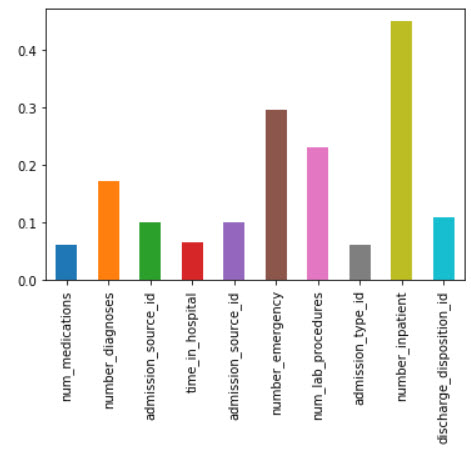

In [3]:
from IPython.display import Image
Image(filename='/Users/mtran/Documents/SMUDataSciences/2019-Summer/Lab2/KNN_Task1.jpg')

For Task 1 Binary Classification of Readmittance from our KNN model, we identified the 10 most important attributes in the classification for re-admittance. Consistent with our previous sort by weight from logistic regression during the Mini Lab, the greater the number of times a patient was an inpatient, the less likely s/he would be re-admitted. Logically, re-admittance declines as the number of emergencies, lab procedures, diagnoses, and prescriptions (number of medications) increases because it more accurately provides the patient with appropriate treatment. Both the classification of the source of admission, e.g. physician referral, ER, clinical referral, etc., and admission type, e.g. ER, elective, newborn, urgent, are also indicative of re-admittance. That is, a physician referral and ER admission suggests a greater factor in re-admittance compared to other referrals and transfers than elective or newborn.  The discharge disposition classification also suggest that a discharge to home vs. discharge/transfer to another facility is significant in re-admittance. The KNN model classification also suggests that longer the time spent in the hospital also decreases the likelihood of re-admittance. 

###### Random Forest

In [ ]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=df_imputed.columns)
feat_importances.nlargest(15).plot(kind='barh')

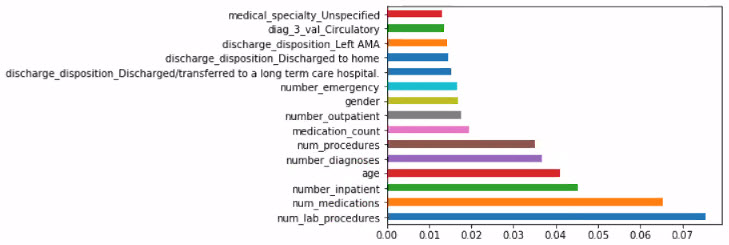

In [6]:
from IPython.display import Image
Image(filename='/Users/mtran/Documents/SMUDataSciences/2019-Summer/Lab2/RF_Task1.jpg')

Using a Random Forest classification generally means feeding as much features as we can to the model and letting the algorithm give back the list of features that it found to be most useful for prediction. In this case, similar to the KNN model, the Random Forest model classification identified the number of lab procedures, prescriptions, times a patient was an inpatient, diagnoses, emergencies, and discharge dispositions as most important attributes. However, it also identified age, gender, number of procedures, and times a patient is an outpatient as important attributes in re-admittance. Also, unlike KNN, the Random Forest model also identified specific discharge disposition, diagnosis, and medical specialty values as more important attributes for re-admittance. The longer the bar, the more important the attribute in contributing new information to the model.

###### SVM

In [ ]:
# SAM to write 

In [ ]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['readmitted_tf'])
df_grouped = df_imputed.groupby(['readmitted_tf'])

# plot KDE of Different variables
vars_to_plot = ['age','gender','num_lab_procedures','medication_count']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['readmitted_0','readmitted_1'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['readmitted_0','readmitted_1'])
    plt.title(v+' (Original)')

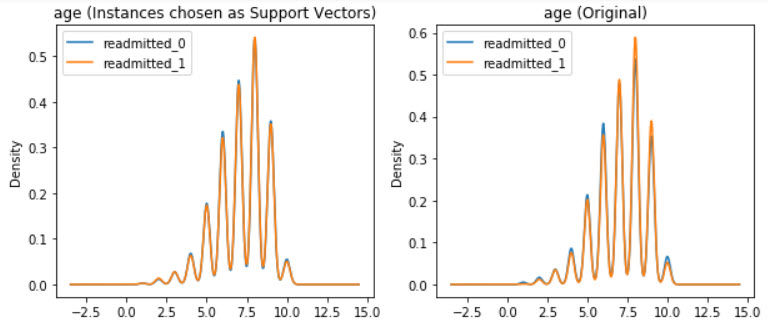

In [9]:
from IPython.display import Image
Image(filename='/Users/mtran/Documents/SMUDataSciences/2019-Summer/Lab2/SVM_Task1_age.jpg')

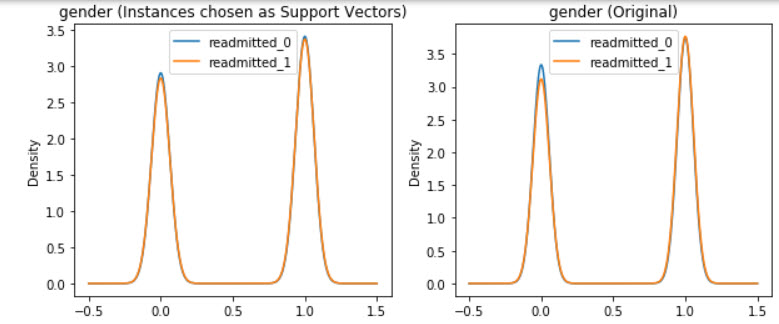

In [10]:
from IPython.display import Image
Image(filename='/Users/mtran/Documents/SMUDataSciences/2019-Summer/Lab2/SVM_Task1_gender.jpg')

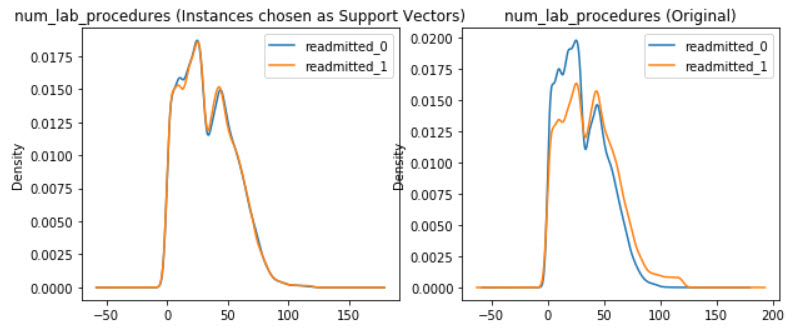

In [11]:
from IPython.display import Image
Image(filename='/Users/mtran/Documents/SMUDataSciences/2019-Summer/Lab2/SVM_Task1_num_lab_proc.jpg')

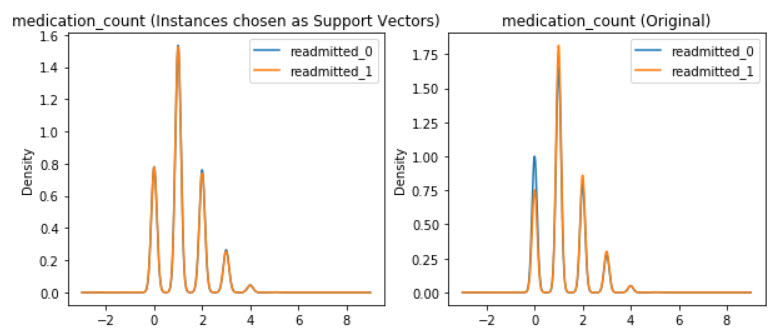

In [12]:
from IPython.display import Image
Image(filename='/Users/mtran/Documents/SMUDataSciences/2019-Summer/Lab2/SVM_Task1_med_count.jpg')

#### Task Two Feature Importance: Regression of Time in Hospital

###### KNN

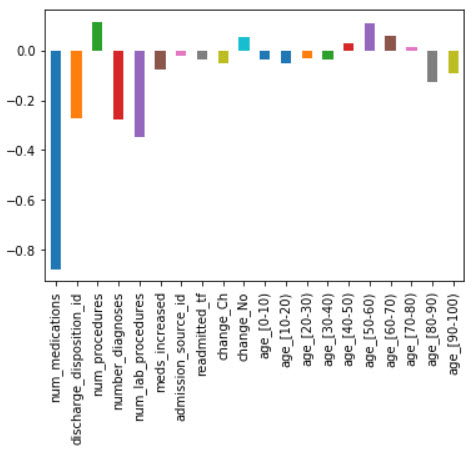

In [4]:
from IPython.display import Image
Image(filename='/Users/mtran/Documents/SMUDataSciences/2019-Summer/Lab2/KNN_Task2.jpg')

For Task 2, the KNN model again identified the number of prescriptions (medications) as most important attribute, with subsequent importance attributed to the number of lab procedures, diagnoses, discharge disposition in determining the time a patient would spend in the hospital. Additionally, its classification of time in hospital to re-admittance, change, and the differing age groups as the nearest neighbors identified them as also important.

###### Random Forest

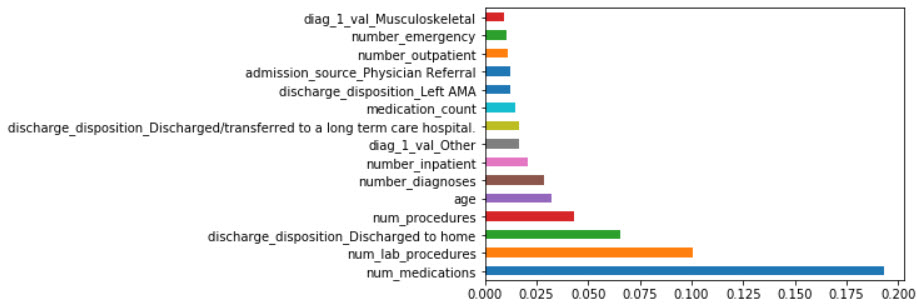

In [7]:
from IPython.display import Image
Image(filename='/Users/mtran/Documents/SMUDataSciences/2019-Summer/Lab2/RF_Task2BEFORE.jpg')

The Random Forest classification for Task 2 identified that number of prescriptions (medications), lab procedures, procedures, emergencies, time a patient is an inpatient or outpatient, varying discharge dispositions and diagnoses, age,  and specifically, physician referral as an admission source in determining the time in the hospital. It is interesting that in the above output, the number of prescriptions (medications) increases prediction RMSE most if it gets shuffled or removed from the model as the most important feature.

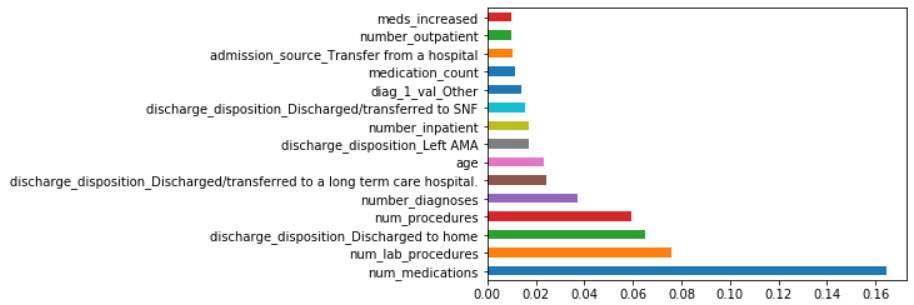

In [8]:
from IPython.display import Image
Image(filename='/Users/mtran/Documents/SMUDataSciences/2019-Summer/Lab2/RF_Task2AFTERTuning.jpg')

After parameter tuning, the Random Forest model still reflects the number of prescriptions (medications) as the most important attribute in the model. Where it kept most of the attributes identified as important prior to tuning, it switched out the various values of discharge disposition and admission source, replacing the number of emergencies with medications increased as more important predictors of time in hospital.

###### Linear Regression

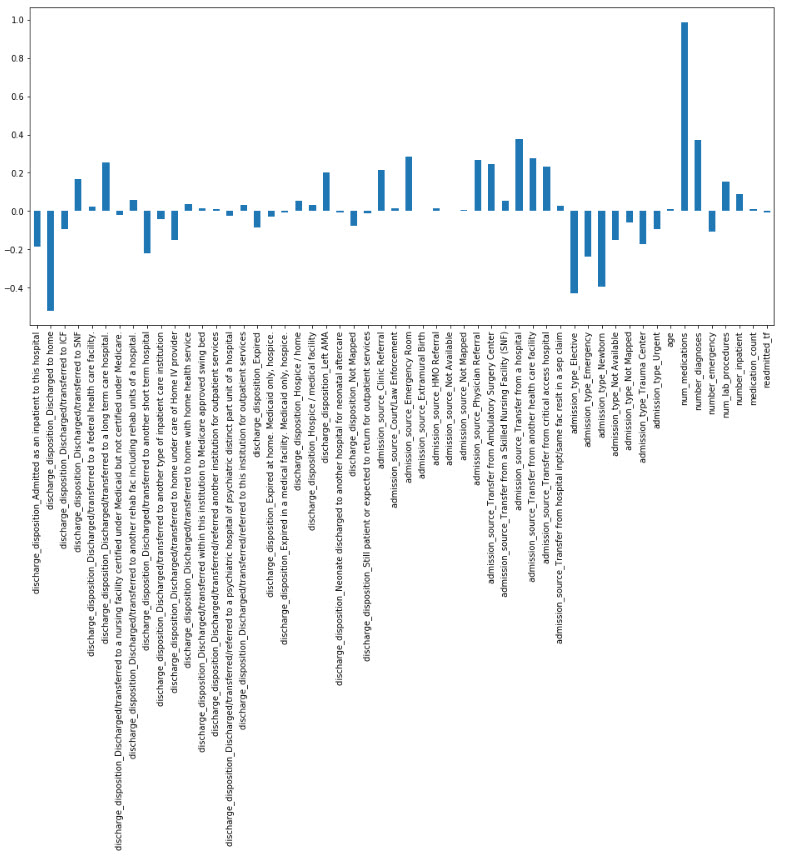

In [13]:
from IPython.display import Image
Image(filename='/Users/mtran/Documents/SMUDataSciences/2019-Summer/Lab2/LR_Task2.jpg')

With Linear Regression as with both the KNN and Random Forest models, the number of predictions (medications) contribute the most new information to the model in predicting time in hospital. In the above graph, the variables with the longer bars are more important than the  ones with shorter bars.

<a id="Deployment"></a>
## Deployment

**Requirement**:
    
• How useful is your model for interested parties (i.e., the companies or
organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

**Answer**: 

Task One: Binary Classification of Readmittance
* Purpose: The purpose of our model for task one is predict the likelihood a patient would be readmitted into the hospital. 

* Interested Party: We believe that all hospitals would be interested in an algorithm that could predict with high accuracy (or high AUC) the likelihood a patient would be readmitted into their facilities. There are a couple of reasons for this: 
1. outcomes from this model would allow for the ability to help in forecasting occupancy and vacancy for their ER. This could be used when forecasting costs of materials and staffing, establishing budgets, applying for grants, and measuring operational efficiency. 
2. Outcomes from this model could flag patients with higher risk and needs for extra care to avoid readmittance. 

* Value: The model value could be measured by the increase in efficiency of ER operations (measuring the number of vacant beds, occupied beds, over capacity, over time, etc). Increase in efficency can result in reduced costs appropriate staffing leveling to service patients leading to less readmittance. Another value of the model is by measure of the increase in grant money assigned to the hospital for facility and equipment upgrades, etc. The measure of the model's value to the hospital readmittance rate over time, when shown to be a decline in readmittance rate suggests patient treatment sucess stories that lends to better reviews of the hospital and talent recruitment.

* Deploy: In order to deploy this model within the hospital network, we would need to deploy this on a system with access to patient data to capture the variable inputs. In addition, model outputs would need to be consumed and reportable to hospital management as predictors of readmittance as a measure of operational effectiveness. 

* Other Data: Other data that could be collected is prior patient pre-existing conditions, intake vitals, and lab outcomes. With these additional data points, the model could be retrained for increased precision. Another interesting way to look at this data would be if we had a time component. The complexity would increase 10-fold, but the information gleaned could be useful. 

* Update Frequency: The model should be retrained when model evaluation metrics fall below 50% or guessing average. Depending on when this information was collected, a retrain should be conducted every 6 months with updated information. By retraining every 6 months, we would be able to keep up with new medical advancements. For example, new labs could be leveraged that provide better accuracy, new medications with better responses could come to market, both of which can cause the population we are modeling to change, thus, needing a retrain. 


Task Two: Regression for Time in Hospital
* Purpose: The purpose of our model for task two is to predict the amount of time a patient is going to spent in the hospital. 

* Interested Party: Similar to task one, the information gleaned from this prediction could aid in forecasting occupancy and vacancy. The same answers apply. Another, different use of this model could be for insurance companies. If an insurance company could predict the amount of time a patient is going to be in the hospital, they could estimate an approxiate value of the payout for the insurance claim.

* Value: The value of this model output could be measured by first testing the % difference between the estimated claim and the actual claim. By doing this, the insurance company can better forecast the amount each insuree could cost, and the total cost for all insurees. This information may also be used in underwriting for life insurance, etc. 

* Deploy: This model would be more complicated to deploy because it would need information from the hospitals (and patients) prior to the insurance claim. For this deployment, there could be two options: hospital to deploy and own the results of the model and sell to insurance companies. The other option is that the insurance company is able to buy access to the insuree's data (with insuree consent). If the hospital owns and deploys their own model and sells the outputs to the insurance company, the hospital would need to deploy the model on servers that have access to patient data. If the health insurnace company owns the model, they will need to find a way to consume the data from the hospital and store that information on their servers for processing. 

* Other Data: Other data to help add the regression model is similar to the data elements described above. Using prior insurance claims and patient details could be helpful as well for this model. 

* Update Frequency: Update frequency is similar to the one explained above. Model evaluation metrics should be measured to identify when a retrain is necessary. 

<a id="Exceptional Work"></a>
## Exceptional Work

**Requirements**: 

• You have free reign to provide additional modeling. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

**Answer**: For our exceptional work feature, we chose to build an XGBoost model for both task one and task two. Extensive research was done to properly train and tune the models. We found significant performance increases by leveraging this technique. See the outcomes below. 

#### XG Boost Research

#### What is boosting?
Boosting is an ML technique that iteratively combines a set of simple and not very accurate classifiers (referred to as "weak" classifiers) into a classifier with high accuracy (a "strong" classifier) by upweighting the examples that the model is currently misclassifying [9].

As opposed to the bagging where trees are built parallelly, in boosting, the trees are built sequentially such that each subsequent tree aims to reduce the errors of the previous tree. Each tree learns from its predecessors and updates the residual errors. Hence, the tree that grows next in the sequence will learn from an updated version of the residuals [2].  
1.	Fit a model to the data, F1(X)=Y
2.	Fit a model to the residuals, h1(X) = Y - F1(X)
3.	Create a new model, F2(X) = F1(X) + h1(X) [Note: F2 is boosted version of F1]
and goes on… Fm(X) = F(m-1)(X) + h(m-1)(X)

###### What is gradient descent?
Gradient descent is a technique to minimize loss by computing the gradients of loss with respect to the model's parameters, conditioned on training data. Informally, gradient descent iteratively adjusts parameters, gradually finding the best combination of weights and bias to minimize loss [9].

###### What is gradient boosting?
Gradient boosting employs the gradient descent algorithm to minimize errors in sequential models. The major inefficiency in Gradient Boosting is that it creates one decision tree at a time. To overcome this, Tianqi Chen and Carlos Guestrin built A Scalable Tree Boosting System — XGBoost can be thought of as Gradient Boosting on steroids. It features parallelized tree building, cache-aware access, sparsity awareness, regularization, and weighted quantile sketch as some of its systems optimization and algorithmic enhancements [10].

###### What is the difference between gradient boosting and adaboost?
They differ on how they create the weak learners during the iterative process. At each iteration, adaptive boosting changes the sample distribution by modifying the weights attached to each of the instances. 
Gradient boosting doesn’t modify the sample distribution. Instead of training on a newly sample distribution, the weak learner trains on the remaining errors (so-called pseudo-residuals) of the strong learner [11].

###### Learning rate
Learning rate is a scalar used to train a model via gradient descent. During each iteration, the gradient descent algorithm multiplies the learning rate by the gradient. The resulting product is called the gradient step. Learning rate is a key hyperparameter [8].


###### What is XGBoost?
XGBoost is short for eXtreme gradient boosting. It is a library designed and optimized for boosted tree algorithms. XGBoost is a state-of-the-art a scalable end-to-end tree boosting system, and also have a novel sparsity-aware algorithm for sparse data [1]. It is a proven model in data science competition and hackathons for its accuracy, speed and scale [2].  For classification problems, XGBoost yield the similar or better accuracy with sk-learn but 10 x faster runtime [1].

In XGBoost, we fit a model on the gradient of loss generated from the previous step. In XGBoost, we just modified our gradient boosting algorithm so that it works with any differentiable loss function [2].  

###### How should I interpret XGBoost trees?
You can interpret xgboost model by interpreting individual trees [7].


###### Why does XGBoost perform better than SVM? 
In our project, we find SVM runs significantly longer than RF and XGBoost models, about 20 mins vs 2 mins vs 1 min. Also, the accuracy we got for these three models are:  XGBoost has around 0.75 auc while RF and SVM have similar auc of around 0.67 (see the comparison plot). RF actually has slightly higher auc than SVM.
XGBoost is an ensamble method it uses many trees to take a decision so it gains power by repeating itself. SVM is a linear separator, when data is not linearly separable SVM needs a Kernel to project the data into a space where it can separate it, there lies its greatest strength and weakness, by being able to project data into a high dimensional space SVM can find a linear separation for almost any data but at the same time it needs to use a Kernel and we can argue that there's not a perfect kernel for every dataset [4].

###### What makes xgboost run much faster than many other implementations of gradient boosting?
XGBoost is designed for scale in as its initial goal. Memory optimization, Cache-line optimization, The improvement in terms of model itself, distributed version; push the limit of the tool to fully utilize the resources, so you can run more examples on single node; There is an external memory version, that allows you to store data in disk, without loading all of them in memory [5].

#### XG Boost Classification

In [7]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'readmitted_tf' in df_imputed:
    y = df_imputed['readmitted_tf'].values # get the labels we want
    del df_imputed['readmitted_tf'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

NameError: name 'df_imputed' is not defined

In [ ]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
        # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [ ]:
import xgboost as xgb


#XGBOOST parameters 1
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50
RANDOM_STATE = 2000

#XGBOOST transform data into DMatrix format for modeling
dtrain = xgb.DMatrix(X_train_scaled, y_train)
dvalid = xgb.DMatrix(X_test_scaled, y_test)
type(dtrain)


# XGBoost Parameters 2
params = {}
params['objective'] = 'binary:logistic'
#params['objective'] = 'multi:softmax'
#params['objective'] = 'reg:linear'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]



In [ ]:
%%time
xgb_clf = xgb.train(params,
                   dtrain,
                   MAX_ROUNDS,
                   watchlist,
                   early_stopping_rounds = EARLY_STOP,
                   maximize = True,
                   verbose_eval = VERBOSE_EVAL)


#Wall time: 3min 48s
#[999]	train-auc:0.756217	valid-auc:0.748447

In [ ]:
preds = xgb_clf.predict(dvalid)
print('XGBoost - roc_auc_score: ', roc_auc_score(y_test, preds))

#XGBoost - roc_auc_score:  0.7484469077761282

#### Hyperparameter Tuning - XGBoost

https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

We used both randomized search and grid search for RF models for comparsion purpose. To save time, we only run randomized search for XGBoost.

In addition, due to the limited computation power on my personal computer, I only run on 3-fold validation and limited parameter sampling for a reasonable runtime like 0.5-1 hr. Otherwise, it will take very long time like 5-10 hrs to run. Therefore, this search does not produce a great score (actually worse than baseline model).

Subsampling of 20% of our data also serves the purpose of save runtime. Plus, we found the results is similar with full dataset run.

In [ ]:
#for the sake of time, subsample 20% of our data 

subsam_df_imputed=df_imputed.sample(frac=0.2)
subsam_df_imputed.info()

In [ ]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'readmitted_tf' in df_imputed:
    y = df_imputed['readmitted_tf'].values # get the labels we want
    del df_imputed['readmitted_tf'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

In [ ]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

    # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

#### Randomized Search CV

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
# A parameter grid for XGBoost
#at least include the parameters already included in the baseline model for chance to find one better than base model.
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1, 2],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.9],
        'max_depth': [2, 5]
        }
### watch out for total number of created models 
###difference combination of the features. 
###Altogether, there are 2*2*2*2*2=32 settings.

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [ ]:
# estimate runtime 40 mins
# actual runtime 30 mins
## grid search in a parallized fashion

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

folds = 3
param_comb = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_scaled,y_train), verbose=50, random_state=2000)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train_scaled, y_train)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

### Results - Best hyperparameters
Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=2, learning_rate=0.02, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

 Best normalized gini score for 3-fold search with 3 parameter combinations:
0.5110818135734807

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}

In [ ]:
#run for 
#evaulate the performance of the model best parameters
# timer the training time
start_time = timer(None)

xgb_best = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=2, learning_rate=0.02, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

xgb_best.fit(X_train_scaled, y_train)

timer(start_time)

In [ ]:
# timer the testing time
start_time = timer(None)
preds = xgb_best.predict(X_test_scaled)
timer(start_time)

In [ ]:
print('XGB - roc_auc_score: ', roc_auc_score(y_test, preds)) 

In [ ]:
# The reason I want to keep both baseline model and refined model is to show the effect of Hyperparameter Tuning. 
# To see increase the AUC by what percentage.

XGBrandom_accuracy = 0.677932172132421
XGBbase_accuracy =0.748447

print('Improvement of {:0.2f}%.'.format( 100 * (XGBrandom_accuracy - XGBbase_accuracy) / XGBbase_accuracy))

Not surprisingly, this search does not produce a great score because of 3-fold validation and limited parameter sampling. The randomized grid search is only for demo purpose. We should provide a larger list of parameters in practice.

###### XG Boost Feature Performance

In [ ]:
fig, ax = plt.subplots(ncols = 1, figsize = (15, 25))
xgb.plot_importance(xgb_clf, height = 0.5, title = 'Feature Importance - XGBoost', ax = ax, color = 'green')
plt.show()

###### XG Boost Evaluation of AUC's

In [ ]:
#histogram to compare auc of models
#SVM AUC: 0.6658213006434637
# Random Forest - roc_auc_score:  0.6745548227288356
#XGBoost - roc_auc_score:  0.7516461447594301
#KNN ?? say 0.7


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bring some raw data.
ROC_AUC_Scores = [0.6658, 0.6745, 0.7516, 0.7]

# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series.from_array(ROC_AUC_Scores)

x_labels = ["SVM","RF","XGBoost","KNN"]

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Model Comparsion _ basline models')
ax.set_xlabel('Model Name')
ax.set_ylabel('ROC_AUC_Score')
ax.set_xticklabels(x_labels)


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.4f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

#### XG Boost Regression

In [ ]:

# XGBoost baseline model

import xgboost as xgb

#XGBOOST transform data into DMatrix format for modeling
dtrain = xgb.DMatrix(X_train_scaled, y_train)
dvalid = xgb.DMatrix(X_test_scaled, y_test)
type(dtrain)

#XGBOOST parameters 1
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50
RANDOM_STATE = 2000


# XGBoost Parameters 2
params = {}
#params['objective'] = 'binary:logistic'
#params['objective'] = 'multi:softmax'
params['objective'] = 'reg:linear'
#params['objective'] = "reg:squarederror"
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'rmse'
params['random_state'] = RANDOM_STATE

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [ ]:
#Wall time: 5.84 s
#%%time
xgb_reg = xgb.train(params,
                   dtrain,
                   MAX_ROUNDS,
                   watchlist,
                   early_stopping_rounds = EARLY_STOP,
                   maximize = True,
                   verbose_eval = VERBOSE_EVAL)

#[0]	train-rmse:5.02045	valid-rmse:5.0569

In [ ]:
preds = xgb_reg.predict(dvalid)
print('XGBoost_reg - mean_squared_error: ', mean_squared_error(y_test, preds))

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
# A parameter grid for XGBoost
#at least include the parameters already included in the baseline model for chance to find one better than base model.
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1, 2],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.9],
        'max_depth': [2, 5]
        }

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(learning_rate=0.02, n_estimators=600, objective='reg:linear',
                    silent=True, nthread=1)

In [ ]:
# estimate runtime 40 mins
# actual runtime 34 mins
## grid search in a parallized fashion

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

folds = 3
param_comb = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='neg_mean_squared_error', n_jobs=4, cv=skf.split(X_train_scaled,y_train), verbose=50, random_state=2000)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train_scaled, y_train)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

In [ ]:
#run for 
#evaulate the performance of the model best parameters
# timer the training time
start_time = timer(None)

xgb_best = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=2, learning_rate=0.02, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

xgb_best.fit(X_train_scaled, y_train)

timer(start_time)

#training time

In [ ]:
# timer the testing time
start_time = timer(None)
preds = xgb_best.predict(X_test_scaled)
timer(start_time)
#testing time

In [ ]:
#predicted_time_in_hospital
preds[:10]

In [ ]:

print('XGBoost_reg - mean_squared_error: ', mean_squared_error(y_test, preds))

In [ ]:
# mse decrease after parameter tuning
random_mse = 5.585353165243333
base_mse = 7.900710644325338

print('Improvement of {:0.2f}%.'.format( 100 * (base_mse - random_mse) / base_mse))
#Improvement of 29.31%. afater parameters tuning

In [ ]:
# after parameters tuning
# XGBoost_reg - mean_squared_error:  5.585353165243333
#       RF_reg - mean_squared_error: 5.835765214548177

In [ ]:
#histogram to compare MSE of models
# LR 7.175072072572132
#KNN ?? say 5.6

# XGBoost_reg - mean_squared_error:  5.585353165243333
#       RF_reg - mean_squared_error: 5.835765214548177


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bring some raw data.
ModelMSEs = [7.175072072572132, 5.835765214548177, 5.585353165243333, 5.6]

# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series.from_array(ModelMSEs)

x_labels = ["LR","RF","XGBoost","KNN"]

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Model Comparsion _ basline models')
ax.set_xlabel('Model Name')
ax.set_ylabel('mean_squared_error(MSE)')
ax.set_xticklabels(x_labels)


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.4f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

<a id="References"></a>
## References

[1] Tavish Srivastava. Analytics Vidhya. Webiste. https://www.analyticsvidhya.com/blog/2016/02/7-important-model-evaluation-error-metrics/

[2] Alice Zheng. OReilly. Website. https://www.oreilly.com/ideas/evaluating-machine-learning-models/page/3/evaluation-metrics

[3] Shruti Saxena. Towards Data Science. Website. https://towardsdatascience.com/precision-vs-recall-386cf9f89488

[4] Kevin Markham. Data School. Website.
https://www.dataschool.io/roc-curves-and-auc-explained/

[5] George Seif. Towards Data Science. Website. https://towardsdatascience.com/selecting-the-best-machine-learning-algorithm-for-your-regression-problem-20c330bad4ef

[6] Alvira Swalin. Medium. USF-Data Science. Website. https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4

[7] Chen et al 2016. XGBoost: A Scalable Tree Boosting System https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf

[8] Website. https://medium.com/@pushkarmandot/how-exactly-xgboost-works-a320d9b8aeef

[9] Google. Website. https://developers.google.com/machine-learning/glossary

[10] LICDN Media. Website. https://media.licdn.com/dms/document/C4D1FAQF_5vlXos139Q/feedshare-document-pdf-analyzed/0?e=1561834800&v=beta&t=GuChwPbOqD4OZz3vKAvfF81lRmtycXS6dooNNHeafTw 

[11] Read the Docs. Website. https://xgboost.readthedocs.io/en/latest/python/ 

[12] Github. Website. https://github.com/dmlc/xgboost/tree/master/python-package

[13] Kardi Teknomo, PhD. Evoledu.  https://people.revoledu.com/kardi/tutorial/KNN/Strength%20and%20Weakness.htm